In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import hamming_loss, f1_score, accuracy_score

### 1. 데이터 불러오기

In [2]:
# FashionMNIST 데이터 불러오기

fm = fetch_openml('Fashion-MNIST', version=1, as_frame=False)

### 2. 데이터 준비 및 분할

In [3]:
# 특징과 타겟 분리
X, y = fm.data, fm.target.astype(int)

# X 미리 표준화 (StandardScaler) 사용

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 60,000개 기준으로 훈련 및 검증 테스트 데이터 분리
X_train, X_test = X_scaled[:60000], X_scaled[60000:]
y_train, y_test = y[:60000], y[60000:]

# 학습용 데이터 중 본 실습에서는 2000개만 사용
X_train_small = X_train[:2000]
y_train_small = y_train[:2000]

### 3. 멀티 클래스 분류 실습

In [4]:
# 분류 실험을 위한 공통 함수 정의

plt.rcParams['font.family'] = 'AppleGothic'

def run_multiclass(model, name):
    print(f"모델: {name}")
    
    # 3-2. 교차 검증 정확도 확인
    scores = cross_val_score(model, X_train_small, y_train_small, cv=3, scoring='accuracy')
    print("교차검증 정확도 평균:", scores.mean())
    
    # 3-3. 교차 예측 결과 추출
    y_pred_cv = cross_val_predict(model, X_train_small, y_train_small, cv=3)
    
    # 3-4. 혼동행렬 시각화 (정규화된 비율)
    ConfusionMatrixDisplay.from_predictions(y_train_small, y_pred_cv, normalize='true')
    plt.title(f"{name} - 혼동행렬")
    plt.show()
    
    # 3-5. 모델 학습 및 예측
    model.fit(X_train_small, y_train_small)
    y_pred = model.predict(X_test)
    
    # 3-6. 최종 평가 결과 출력
    print("테스트 데이터 분류 리포트:")
    print(classification_report(y_test, y_pred, zero_division=0))

모델: SGDClassifier (OvO)
교차검증 정확도 평균: 0.8105069087078083


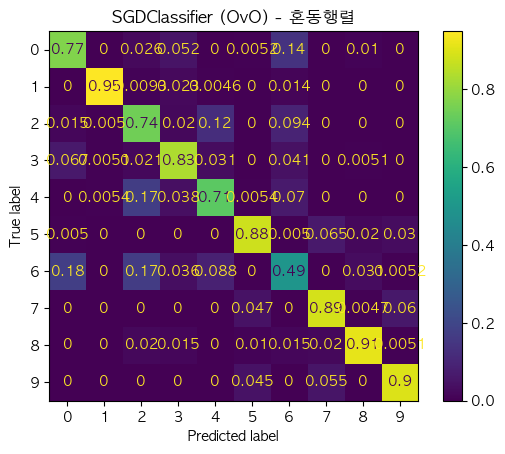

테스트 데이터 분류 리포트:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1000
           1       0.96      0.94      0.95      1000
           2       0.63      0.73      0.68      1000
           3       0.82      0.81      0.81      1000
           4       0.70      0.63      0.66      1000
           5       0.92      0.86      0.89      1000
           6       0.50      0.53      0.51      1000
           7       0.86      0.92      0.89      1000
           8       0.93      0.91      0.92      1000
           9       0.92      0.91      0.91      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [5]:
# 세 가지 모델 적용
# 1. SGDClassifier(OvO, One-vs-One 래퍼 사용)
run_multiclass(OneVsOneClassifier(SGDClassifier(loss='log_loss', random_state=42)), "SGDClassifier (OvO)")

모델: SVC (OvR)
교차검증 정확도 평균: 0.8165046605826216


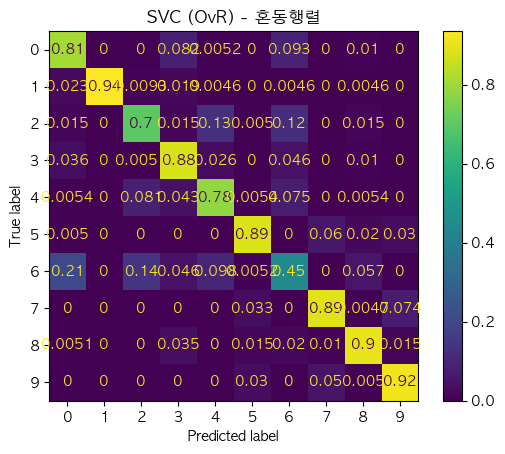

테스트 데이터 분류 리포트:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1000
           1       0.99      0.93      0.96      1000
           2       0.73      0.69      0.71      1000
           3       0.80      0.87      0.83      1000
           4       0.70      0.73      0.71      1000
           5       0.91      0.89      0.90      1000
           6       0.57      0.50      0.53      1000
           7       0.89      0.89      0.89      1000
           8       0.90      0.95      0.92      1000
           9       0.89      0.92      0.90      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [6]:
# 2) SVC(OvR)
run_multiclass(SVC(), "SVC (OvR)")

모델: KNeighborsClassifier
교차검증 정확도 평균: 0.7740026383204794


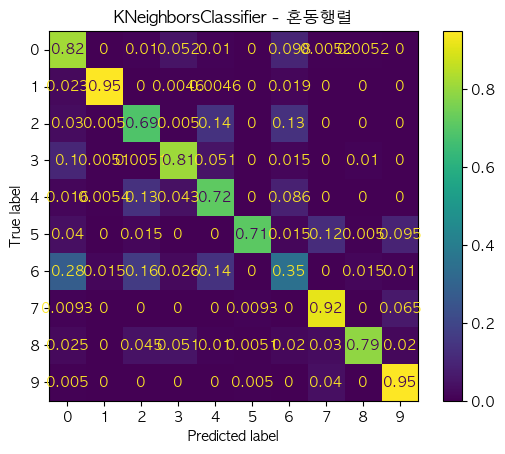

테스트 데이터 분류 리포트:
              precision    recall  f1-score   support

           0       0.64      0.85      0.73      1000
           1       0.96      0.93      0.95      1000
           2       0.61      0.68      0.64      1000
           3       0.85      0.79      0.81      1000
           4       0.66      0.68      0.67      1000
           5       0.96      0.70      0.81      1000
           6       0.56      0.43      0.49      1000
           7       0.80      0.92      0.86      1000
           8       0.96      0.86      0.91      1000
           9       0.85      0.93      0.89      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



In [7]:
# 3) KNeighborsClassifier(다중 클래스 기본 지원)
run_multiclass(KNeighborsClassifier(n_neighbors=5), "KNeighborsClassifier")

### 4. 멀티 라벨 분류 실습

In [8]:
# 총 10 종류를 가진 단일 라벨을, 상의, 하의, 신발 3가지로 분리해 멀티 라벨로 변경
upper = np.isin(y_train, [0, 2, 3, 4, 6])   # 상의, isin 하면 true, false 이런식으로 분류해서 나옴 (0,2,3,4,6 등에 대해)
lower = np.isin(y_train, [1, 3])           # 하의
shoes = np.isin(y_train, [5, 7, 9])        # 신발

# (60000, 3) 형태의 멀티라벨 타겟 생성
y_train_multilabel = np.c_[upper, lower, shoes]

In [9]:
# 멀티라벨 학습 및 평가 함수

def run_multilabel(model, name):
    print(f"멀티라벨 모델: {name}")
    
    # 4-3. 학습 및 예측
    model.fit(X_train_small, y_train_multilabel[:2000])
    y_pred = model.predict(X_train_small)
    
    # 4-4. 지표 확인
    print("정확도:", accuracy_score(y_train_multilabel[:2000], y_pred))
    print("Hamming Loss:", hamming_loss(y_train_multilabel[:2000], y_pred))
    print("F1 Score (macro):", f1_score(y_train_multilabel[:2000], y_pred, average='macro'))
    
    # 4-5. classification_report
    target_names = ["Upper", "Lower", "Shoes"]
    print("classification_report (각 클래스별):")
    print(classification_report(y_train_multilabel[:2000], y_pred, target_names=target_names, zero_division=0))

In [10]:
# 두 가지 멀티라벨 분류기 실행
run_multilabel(KNeighborsClassifier(n_neighbors=5), "KNeighborsClassifier")
run_multilabel(ClassifierChain(SGDClassifier(loss='log_loss', random_state=42)), "ClassifierChain (SGDClassifier)") # 누적시켜서 계속 그 결과를 다음 거에 넣는 게 classifierchain
# 모든 뷴류는 이 전체 코드의 큰 흐름을 따른다

멀티라벨 모델: KNeighborsClassifier
정확도: 0.955
Hamming Loss: 0.018333333333333333
F1 Score (macro): 0.9673334009779927
classification_report (각 클래스별):
              precision    recall  f1-score   support

       Upper       0.96      0.99      0.98       971
       Lower       0.97      0.91      0.94       411
       Shoes       0.99      0.99      0.99       615

   micro avg       0.97      0.97      0.97      1997
   macro avg       0.97      0.96      0.97      1997
weighted avg       0.97      0.97      0.97      1997
 samples avg       0.89      0.88      0.88      1997

멀티라벨 모델: ClassifierChain (SGDClassifier)
정확도: 0.992
Hamming Loss: 0.0026666666666666666
F1 Score (macro): 0.9938431326515631
classification_report (각 클래스별):
              precision    recall  f1-score   support

       Upper       1.00      1.00      1.00       971
       Lower       1.00      0.97      0.98       411
       Shoes       1.00      1.00      1.00       615

   micro avg       1.00      0.99      1.00  